# Crypto Index: Monthly Rebalancing Backtest

This notebook simulates **five portfolio strategies** with monthly
rebalancing over January to December 2025:

| Strategy | Method | Assets |
|----------|--------|--------|
| A | BTC buy-and-hold benchmark | 1 |
| B | Correlation tournament + inverse-vol weights | 20 |
| C | K-Means cluster-balanced selection | 20 |
| D | PCA residual variance (most market-independent) | 20 |
| E | GBT predicted-return ranking | 20 |

Each strategy uses a rolling **90-day lookback** window ending at the
start of the rebalance month. The backtest enforces strict tradability:
an asset must have an exact 4h candle at rebalance time to be invested.

All computation uses **Apache Spark**. No pandas.

Output/display order follows **A -> B -> C -> D -> E**.


## Overview

This notebook implements a **backtesting framework** for cryptocurrency portfolio strategies using Apache Spark. The goal is to evaluate and compare five distinct portfolio construction methodologies.

### Key Features

- **Spark-based implementation**: All data processing and model fitting uses Spark DataFrames
- **No lookahead bias**: Assets are selected only using past data
- **Rolling window design**: Each month uses only the prior 90 days for model fitting
- **Realistic constraints**: Models delisting and missing data scenarios

### Backtest Specifications

| Parameter | Value | Rationale |
|-----------|-------|-----------|
| Initial Capital | $10,000 | Standard baseline for comparison |
| Lookback Window | 90 days | Balances recency vs. statistical significance |
| Rebalance Frequency | Monthly | Realistic for crypto portfolios |
| Portfolio Size | 20 assets (B-E), 1 asset (A) | Diversification without excessive complexity |
| Backtest Period | Jan–Dec 2025 | Full calendar year |
| Data Frequency | 4-hour candles | Sufficient resolution for crypto volatility |

### Research Questions

1. Does diversification improve risk-adjusted returns compared to holding BTC?
2. Which selection methodology delivers the best Sharpe ratio?
3. How do different strategies perform across varying market conditions?

## 1. Setup


In [ ]:
import findspark
try:
    findspark.init()
except Exception:
    pass

import os, csv
import numpy as np
# In notebooks we use the default interactive backend (no Agg).
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import KMeans
from pyspark.ml.regression import GBTRegressor

In [ ]:
# Data
DATA_SOURCE = "crypto_data_parquet"
OUTPUT_FOLDER = "output"

# Backtest parameters
INITIAL_CAPITAL = 10000.0
LOOKBACK_DAYS = 90
BACKTEST_YEAR = 2025
BACKTEST_START_MONTH = 1
BACKTEST_END_MONTH = 12

# Strategy parameters
CORRELATION_THRESHOLD = 0.85
TOP_N_ASSETS = 20
N_CLUSTERS = 5
N_PCA_COMPONENTS = 10
MAX_WIDE_MATRIX_SYMBOLS = 150  # cap for Spark codegen stability

# Annualisation constants (4h candles)
CANDLES_PER_DAY = 6
ANN_PERIODS = 365 * CANDLES_PER_DAY

# Reporting labels (A->E) used in plots/tables/results.
# Internal model functions remain strategy_a...strategy_e blocks below.
STRATEGY_NAMES = {
    "A": "BTC Buy & Hold (Benchmark)",
    "B": "Correlation-based (Top 20)",
    "C": "K-Means Cluster-Balanced (Top 20)",
    "D": "PCA Residual Variance (Top 20)",
    "E": "GBT Prediction (Top 20)",
}
STRATEGY_DISPLAY_ORDER = ["A", "B", "C", "D", "E"]


### Parameter Justification

**CORRELATION_THRESHOLD = 0.85**: Assets with |ρ| > 0.85 are considered highly correlated. In portfolio theory, such pairs provide minimal diversification benefit, so we eliminate the lower-Sharpe asset from each correlated pair.

**TOP_N_ASSETS = 20**: Strikes a balance between diversification and concentration. Academic research suggests optimal portfolio size is 15-30 assets for most markets.

**N_CLUSTERS = 5**: Based on the elbow method analysis (see notebook 02), 5 clusters capture distinct risk/return profiles in the crypto universe without over-segmentation.

**N_PCA_COMPONENTS = 10**: Retains ~80-90% of variance in typical crypto return matrices while reducing dimensionality for computational stability.

**MAX_WIDE_MATRIX_SYMBOLS = 150**: Prevents Spark codegen failures when pivoting wide DataFrames. This is a technical limitation, not a portfolio constraint.

**LOOKBACK_DAYS = 90**: Approximately 3 months of data provides:
- Sufficient observations for statistical significance (~540 4h candles)
- Recency to capture current market regime
- Stability against short-term noise

**CANDLES_PER_DAY = 6**: For 4-hour candles (24h / 4h = 6 candles/day), used to annualize volatility and returns consistently.

In [3]:
spark = (
    SparkSession.builder
    .appName("CryptoBacktest")
    .config("spark.driver.memory", "6g")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.sql.shuffle.partitions", "20")
    .config("spark.sql.codegen.hugeMethodLimit", "8000")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")
print("Spark version:", spark.version)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/12 20:31:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 4.1.1


## 2. Data Ingestion

We load all available data and assign a `month_id` column that maps
calendar months to our backtest timeline:

| month_id | Calendar month | Role |
|----------|---------------|------|
| -2 | Oct 2024 | Warmup only |
| -1 | Nov 2024 | Warmup only |
|  0 | Dec 2024 | Lookback only |
|  1 | Jan 2025 | First traded month |
| ... | ... | ... |
| 12 | Dec 2025 | Last traded month |


In [4]:
if not os.path.exists(DATA_SOURCE):
    raise FileNotFoundError(f"Data not found: {DATA_SOURCE}. Run notebook 01 first.")

raw_df = spark.read.parquet(DATA_SOURCE)

# month_id: Oct 2024 = -2, Nov 2024 = -1, Dec 2024 = 0, Jan 2025 = 1, ..., Dec 2025 = 12
raw_df = raw_df.withColumn(
    "month_id",
    F.when(F.col("year") == 2024, F.col("month") - 12)
     .otherwise(F.col("month"))
)

long_df = (
    raw_df
    .select(
        F.col("timestamp"), F.col("symbol"),
        F.col("close").cast("double"), F.col("month_id"),
    )
    .filter(F.col("close").isNotNull())
    .cache()
)

total = long_df.count()
symbols = sorted([r.symbol for r in long_df.select("symbol").distinct().collect()])
print(f"Loaded {total:,} rows across {len(symbols)} assets")

# Show month distribution
long_df.groupBy("month_id").count().orderBy("month_id").show(20)

Loaded 1,110,662 rows across 501 assets
+--------+-----+
|month_id|count|
+--------+-----+
|      -2|71220|
|      -1|69295|
|       0|72108|
|       1|72718|
|       2|66597|
|       3|74209|
|       4|71889|
|       5|73845|
|       6|72556|
|       7|74985|
|       8|75880|
|       9|75109|
|      10|80037|
|      11|78781|
|      12|81433|
+--------+-----+



### Interpretation

The ingestion output confirms the expected warmup + backtest timeline is present in the data.
This is important because the 90-day lookback for early 2025 months depends on Oct-Dec 2024 coverage.


## 3. Rebalance Windows

For each of the 12 backtest months we define:
- A **lookback window** (90 days before month start) used for model fitting
- A **holding period** (the full calendar month) during which positions are held


In [5]:
def next_month_start(dt):
    if dt.month == 12:
        return datetime(dt.year + 1, 1, 1)
    return datetime(dt.year, dt.month + 1, 1)

windows = []
for month in range(BACKTEST_START_MONTH, BACKTEST_END_MONTH + 1):
    hold_start = datetime(BACKTEST_YEAR, month, 1)
    hold_end = next_month_start(hold_start)
    lb_end = hold_start
    lb_start = hold_start - timedelta(days=LOOKBACK_DAYS)
    windows.append((month, lb_start, lb_end, hold_start, hold_end))

print(f"Created {len(windows)} rebalance windows ({LOOKBACK_DAYS}-day lookback)\n")
print(f"  {'Month':>5}  {'Lookback':^30s}  {'Holding':^30s}")
for m, lbs, lbe, hs, he in windows[:3]:
    print(f"  {m:>5d}  {lbs:%Y-%m-%d} to {lbe - timedelta(days=1):%Y-%m-%d}  "
          f"{hs:%Y-%m-%d} to {he - timedelta(days=1):%Y-%m-%d}")
print("  ...")
m, lbs, lbe, hs, he = windows[-1]
print(f"  {m:>5d}  {lbs:%Y-%m-%d} to {lbe - timedelta(days=1):%Y-%m-%d}  "
      f"{hs:%Y-%m-%d} to {he - timedelta(days=1):%Y-%m-%d}")

Created 12 rebalance windows (90-day lookback)

  Month             Lookback                        Holding            
      1  2024-10-03 to 2024-12-31  2025-01-01 to 2025-01-31
      2  2024-11-03 to 2025-01-31  2025-02-01 to 2025-02-28
      3  2024-12-01 to 2025-02-28  2025-03-01 to 2025-03-31
  ...
     12  2025-09-02 to 2025-11-30  2025-12-01 to 2025-12-31


###  Interpretation

The window table verifies there are exactly **12 monthly rebalances** in 2025, each with a rolling 90-day lookback.
This matches our experiment design and prevents accidental leakage from outside the intended period.


## 4. Helper Functions

Shared utilities used by all strategies: time-window filtering,
per-asset metric calculation, and correlation matrix computation.


In [ ]:
def filter_window(df, start, end):
    """Filter dataframe to [start, end) by timestamp."""
    return df.filter(
        (F.col("timestamp") >= F.lit(start)) &
        (F.col("timestamp") < F.lit(end))
    )

def calc_metrics(long_df, lb_start, lb_end):
    """Compute annualised return, volatility, and Sharpe for each asset."""
    data = filter_window(long_df, lb_start, lb_end)
    w = Window.partitionBy("symbol").orderBy("timestamp")
    df = (
        data
        .withColumn("prev", F.lag("close").over(w))
        .withColumn("log_ret", F.log(F.col("close") / F.col("prev")))
        .filter(F.col("log_ret").isNotNull())
    )
    m = (
        df.groupBy("symbol")
        .agg(
            F.count("log_ret").alias("count"),
            F.sum("log_ret").alias("sum_lr"),
            F.stddev("log_ret").alias("std_lr"),
        )
        .filter(F.col("count") > 30)
        .withColumn("annual_ret", F.col("sum_lr") * (ANN_PERIODS / F.col("count")))
        .withColumn("annual_vol", F.col("std_lr") * np.sqrt(ANN_PERIODS))
        .withColumn("sharpe", F.col("annual_ret") / F.col("annual_vol"))
    )
    return m

def calc_corr_matrix(long_df, lb_start, lb_end, sym_list):
    """Compute Pearson correlation matrix on log returns for given symbols."""
    if len(sym_list) < 2:
        return np.empty((0, 0)), []
    data = filter_window(long_df, lb_start, lb_end)
    w = Window.partitionBy("symbol").orderBy("timestamp")
    df = (
        data
        .withColumn("prev", F.lag("close").over(w))
        .withColumn("ret", F.log(F.col("close") / F.col("prev")))
        .filter(F.col("ret").isNotNull())
        .select("timestamp", "symbol", "ret")
    )
    wide = df.groupBy("timestamp").pivot("symbol", sym_list).agg(F.first("ret")).fillna(0)
    cols = [c for c in sym_list if c in wide.columns]
    if len(cols) < 2:
        return np.empty((0, 0)), []
    asm = VectorAssembler(inputCols=cols, outputCol="features")
    vec = asm.transform(wide).select("features")
    mat = Correlation.corr(vec, "features", "pearson").head()[0].toArray()
    return mat, cols

### Helper Function Design

**filter_window()**: Time-based filtering is critical to prevent lookahead bias. The function uses strict inequality on the end timestamp to ensure we never accidentally include future data.

**calc_metrics()**: Computes annualized Sharpe ratio for each asset using log returns:
- **Why log returns?** They're time-additive and handle compound growth correctly
- **Why annualize?** Allows comparison across different data frequencies
- **Filter threshold (count > 30)**: Ensures statistical validity of volatility estimates

**calc_corr_matrix()**: Builds a Pearson correlation matrix on log returns:
- **Why Pearson?** Linear correlation is sufficient for identifying redundant exposures
- **Wide pivot design**: Transforms long-format data into a timestamp × symbol matrix for efficient correlation computation
- **Zero-fill for missing values**: Conservative assumption that missing returns = 0%

These helpers are shared across all strategies to ensure fair comparison.

## 5. Model Block: Correlation-Based Tournament (used for Portfolio B)

**Algorithm:**
1. Compute per-asset metrics over the 90-day lookback
2. Build a Pearson correlation matrix on log returns
3. For each pair with |rho| > 0.85, drop the lower-Sharpe asset
4. Select the top 20 survivors by Sharpe
5. Assign inverse-volatility weights


### Theoretical Background: Correlation Filtering

**Portfolio Theory Foundation**: Markowitz (1952) demonstrated that portfolio variance depends on pairwise correlations. Assets with ρ > 0.85 offer minimal diversification benefit and can be replaced by a single representative.

**Tournament Approach**: When two assets are highly correlated, we keep the one with higher Sharpe ratio. This is a greedy algorithm that:
- Reduces multicollinearity in the portfolio
- Preserves risk-adjusted return quality
- Avoids concentration in a single market segment

**Inverse-Volatility Weighting**: After selection, we weight assets as $w_i \propto 1/\sigma_i$. This is the "minimum variance" heuristic and tends to:
- De-emphasize volatile assets
- Increase portfolio stability
- Approximate mean-variance optimization when expected returns are uncertain

**Expected Outcome**: This strategy should produce a lower-volatility portfolio than equal-weight, with moderate returns if the crypto market exhibits mean reversion.

In [7]:
def strategy_a(spark, long_df, symbols, lb_start, lb_end):
    metrics_sdf = calc_metrics(long_df, lb_start, lb_end)
    rows = metrics_sdf.select("symbol", "sharpe", "annual_vol").collect()
    if not rows:
        return spark.createDataFrame([], "symbol STRING, weight DOUBLE")

    # Build lookup dicts
    sharpe_map = {r["symbol"]: float(r["sharpe"]) for r in rows}
    vol_map = {r["symbol"]: float(r["annual_vol"]) for r in rows}

    # Cap candidates for Spark codegen stability
    candidates = sorted(
        [(s, sh) for s, sh in sharpe_map.items()
         if vol_map.get(s, 0) > 0],
        key=lambda x: -x[1],
    )[:MAX_WIDE_MATRIX_SYMBOLS]
    cand_syms = [s for s, _ in candidates if s in symbols]

    if len(cand_syms) < 2:
        # Fallback: top-N by Sharpe, inverse-vol weights
        top = candidates[:TOP_N_ASSETS]
        inv = [(s, 1.0 / vol_map[s]) for s, _ in top if vol_map.get(s, 0) > 0]
        total = sum(v for _, v in inv)
        wts = [(s, v / total) for s, v in inv] if total > 0 else []
        return spark.createDataFrame(wts, ["symbol", "weight"])

    corr_mat, valid = calc_corr_matrix(long_df, lb_start, lb_end, cand_syms)
    if len(valid) == 0:
        top = candidates[:TOP_N_ASSETS]
        inv = [(s, 1.0 / vol_map[s]) for s, _ in top if vol_map.get(s, 0) > 0]
        total = sum(v for _, v in inv)
        wts = [(s, v / total) for s, v in inv] if total > 0 else []
        return spark.createDataFrame(wts, ["symbol", "weight"])

    # Tournament filter
    idx2sym = {i: s for i, s in enumerate(valid)}
    keep, dropped = set(valid), set()
    for i in range(len(valid)):
        for j in range(i + 1, len(valid)):
            if abs(corr_mat[i, j]) > CORRELATION_THRESHOLD:
                s1, s2 = idx2sym[i], idx2sym[j]
                if s1 in dropped or s2 in dropped:
                    continue
                sh1 = sharpe_map.get(s1, -999)
                sh2 = sharpe_map.get(s2, -999)
                loser = s1 if sh1 < sh2 else s2
                dropped.add(loser)
                keep.discard(loser)

    # Top N by Sharpe from survivors
    survivors = [(s, sharpe_map[s]) for s in keep if s in sharpe_map]
    survivors.sort(key=lambda x: -x[1])
    top_n = survivors[:TOP_N_ASSETS]

    # Inverse-vol weights
    inv = [(s, 1.0 / vol_map[s]) for s, _ in top_n
           if vol_map.get(s, 0) > 0 and np.isfinite(vol_map.get(s, 0))]
    total = sum(v for _, v in inv)
    if total <= 0:
        return spark.createDataFrame([], "symbol STRING, weight DOUBLE")
    wts = [(s, v / total) for s, v in inv]
    return spark.createDataFrame(wts, ["symbol", "weight"])

## 6. Model Block: K-Means Cluster-Balanced (used for Portfolio C)

**Algorithm:**
1. Compute risk/return metrics and standardise them
2. Fit K-Means (k=5) on [annual_ret, annual_vol, sharpe]
3. Rank assets by Sharpe within each cluster
4. Round-robin across clusters to select a balanced top 20
5. Assign inverse-volatility weights


### Theoretical Background: Cluster-Balanced Selection

**Motivation**: Traditional Sharpe-ranked portfolios often concentrate in a single market segment (e.g., all DeFi tokens or all meme coins). Cluster-based selection enforces **diversity across risk/return regimes**.

**K-Means Clustering**: We cluster assets in (return, volatility, Sharpe) space. Each cluster represents a distinct risk profile:
- Cluster 1: High-return, high-volatility (speculative)
- Cluster 2: Moderate-return, moderate-volatility (balanced)
- Cluster 3: Low-return, low-volatility (defensive)
- Clusters 4-5: Mixed or niche segments

**Round-Robin Selection**: By picking top-Sharpe assets from each cluster in rotation, we:
- Avoid concentration risk
- Capture different market conditions (some clusters perform better in bull markets, others in bear markets)
- Improve portfolio resilience to regime changes

**Expected Outcome**: More stable performance across different market phases, but potentially lower peak returns than a pure Sharpe-maximization strategy.

In [8]:
def strategy_b(spark, long_df, lb_start, lb_end):
    metrics_sdf = calc_metrics(long_df, lb_start, lb_end)

    asm = VectorAssembler(
        inputCols=["annual_ret", "annual_vol", "sharpe"], outputCol="feat_raw"
    )
    df = asm.transform(metrics_sdf)
    sc = StandardScaler(inputCol="feat_raw", outputCol="feat", withStd=True, withMean=True)
    df = sc.fit(df).transform(df)

    km = KMeans(k=N_CLUSTERS, seed=42, featuresCol="feat", predictionCol="cluster")
    clustered = km.fit(df).transform(df)

    # Rank within each cluster
    rw = Window.partitionBy("cluster").orderBy(F.desc("sharpe"))
    ranked = (
        clustered
        .withColumn("rank", F.row_number().over(rw))
        .select("symbol", "cluster", "sharpe", "annual_vol", "rank")
        .collect()
    )
    if not ranked:
        return spark.createDataFrame([], "symbol STRING, weight DOUBLE")

    # Group by cluster
    from collections import defaultdict
    by_cluster = defaultdict(list)
    for r in ranked:
        by_cluster[int(r["cluster"])].append({
            "symbol": r["symbol"],
            "sharpe": float(r["sharpe"]),
            "vol": float(r["annual_vol"]),
            "rank": int(r["rank"]),
        })
    for cl in by_cluster:
        by_cluster[cl].sort(key=lambda x: x["rank"])

    # Round-robin selection
    cluster_ids = sorted(by_cluster.keys())
    pos = {cl: 0 for cl in cluster_ids}
    selected = []
    while len(selected) < TOP_N_ASSETS:
        added = False
        for cl in cluster_ids:
            if pos[cl] < len(by_cluster[cl]):
                selected.append(by_cluster[cl][pos[cl]])
                pos[cl] += 1
                added = True
                if len(selected) >= TOP_N_ASSETS:
                    break
        if not added:
            break

    # Inverse-vol weights
    valid = [s for s in selected if s["vol"] > 0 and np.isfinite(s["vol"])]
    if not valid:
        return spark.createDataFrame([], "symbol STRING, weight DOUBLE")
    inv = [(s["symbol"], 1.0 / s["vol"]) for s in valid]
    total = sum(v for _, v in inv)
    wts = [(s, v / total) for s, v in inv] if total > 0 else []
    return spark.createDataFrame(wts, ["symbol", "weight"])

## 7. Model Block: PCA Residual Variance (used for Portfolio D)

**Algorithm:**
1. Build a returns matrix and fit PCA (k=10) using Spark MLlib
2. Extract PC1 loadings for each asset
3. Residual variance = 1 - (PC1 loading)^2
4. Select the 20 assets with the **highest** residual variance
   (these are least correlated with the broad market factor)
5. Assign inverse-volatility weights

**Rationale:** assets with high residual variance provide genuine
diversification. When the market crashes (PC1 drops), these assets
are less affected.


### Theoretical Background: PCA and Market Independence

**Principal Component Analysis**: In financial markets, PC1 typically captures the "market factor"—the common movement across all assets. An asset's PC1 loading measures how much it moves with the overall market.

**Residual Variance Formula**:
$$\text{Residual}_i = 1 - (\text{PC1 loading}_i)^2$$

This quantifies the proportion of an asset's variance **not explained** by the market factor.

**Why Select High-Residual Assets?**
- **Diversification**: Assets with high residual variance are driven by idiosyncratic factors, not market-wide shocks
- **Crisis resilience**: When the market crashes (PC1 drops), high-residual assets may be less affected
- **Alpha generation**: These assets may offer uncorrelated return sources

**Academic Support**: Fama-French (1993) and other factor models show that idiosyncratic variance can be a source of excess returns, though results are mixed in crypto markets.

**Expected Outcome**: Lower correlation with BTC and market downturns, but potentially lower returns if the market rallies (since we're avoiding the main market factor).

In [9]:
def strategy_c(spark, long_df, symbols, lb_start, lb_end):
    metrics_sdf = calc_metrics(long_df, lb_start, lb_end)
    m_rows = metrics_sdf.select("symbol", "sharpe", "annual_vol").collect()
    if not m_rows:
        return spark.createDataFrame([], "symbol STRING, weight DOUBLE")

    sharpe_map = {r["symbol"]: float(r["sharpe"]) for r in m_rows}
    vol_map = {r["symbol"]: float(r["annual_vol"]) for r in m_rows}

    # Cap candidates
    candidates = sorted(
        [(s, sh) for s, sh in sharpe_map.items() if vol_map.get(s, 0) > 0],
        key=lambda x: -x[1],
    )[:MAX_WIDE_MATRIX_SYMBOLS]
    cand_syms = [s for s, _ in candidates if s in symbols]

    if len(cand_syms) < 2:
        print(f"    [Strategy C warning] {type(exc).__name__}: {exc}")
        top = candidates[:TOP_N_ASSETS]
        inv = [(s, 1.0 / vol_map[s]) for s, _ in top if vol_map.get(s, 0) > 0]
        total = sum(v for _, v in inv)
        wts = [(s, v / total) for s, v in inv] if total > 0 else []
        return spark.createDataFrame(wts, ["symbol", "weight"])

    # Build returns matrix
    data = filter_window(long_df, lb_start, lb_end)
    w = Window.partitionBy("symbol").orderBy("timestamp")
    df = (
        data
        .withColumn("prev", F.lag("close").over(w))
        .withColumn("ret", F.log(F.col("close") / F.col("prev")))
        .filter(F.col("ret").isNotNull())
        .filter(F.col("symbol").isin(cand_syms))
        .select("timestamp", "symbol", "ret")
    )
    wide = df.groupBy("timestamp").pivot("symbol", cand_syms).agg(F.first("ret")).fillna(0)
    cols = [c for c in cand_syms if c in wide.columns]
    if len(cols) < 2:
        top = candidates[:TOP_N_ASSETS]
        inv = [(s, 1.0 / vol_map[s]) for s, _ in top if vol_map.get(s, 0) > 0]
        total = sum(v for _, v in inv)
        wts = [(s, v / total) for s, v in inv] if total > 0 else []
        return spark.createDataFrame(wts, ["symbol", "weight"])

    asm = VectorAssembler(inputCols=cols, outputCol="features")
    vec = asm.transform(wide).select("features")

    k = min(N_PCA_COMPONENTS, len(cols))
    try:
        pca_model = PCA(k=k, inputCol="features", outputCol="pca").fit(vec)
    except Exception as exc:
        top = candidates[:TOP_N_ASSETS]
        inv = [(s, 1.0 / vol_map[s]) for s, _ in top if vol_map.get(s, 0) > 0]
        total = sum(v for _, v in inv)
        wts = [(s, v / total) for s, v in inv] if total > 0 else []
        return spark.createDataFrame(wts, ["symbol", "weight"])

    pc1 = pca_model.pc.toArray()[:, 0]
    residual = 1.0 - pc1 ** 2

    # Pair each symbol with its residual variance
    sym_resid = sorted(zip(cols, residual.tolist()), key=lambda x: -x[1])
    top_resid = sym_resid[:TOP_N_ASSETS]

    # Inverse-vol weights
    inv = [
        (s, 1.0 / vol_map[s])
        for s, _ in top_resid
        if vol_map.get(s, 0) > 0 and np.isfinite(vol_map.get(s, 0))
           and sharpe_map.get(s) is not None and np.isfinite(sharpe_map[s])
    ]
    total = sum(v for _, v in inv)
    if total <= 0:
        return spark.createDataFrame([], "symbol STRING, weight DOUBLE")
    wts = [(s, v / total) for s, v in inv]
    return spark.createDataFrame(wts, ["symbol", "weight"])


## 8. Model Block: BTC Buy & Hold Benchmark (used for Portfolio A)

Simple benchmark: 100% allocation to BTCUSDT, held for the full year.


In [10]:
def strategy_d(spark):
    return spark.createDataFrame([("BTCUSDT", 1.0)], ["symbol", "weight"])

## 9. Strategy E: GBT Return Prediction

**Algorithm:**
1. Engineer technical features over the lookback window
2. Split lookback data chronologically (first 80% train, last 20% validation)
3. Train a Gradient Boosted Trees regressor on the train split
4. Score only the held-out validation split (out-of-sample within lookback)
5. Rank symbols by predicted return and build the portfolio

This avoids in-sample scoring and makes Strategy E more comparable to the other methods.


### Theoretical Background: Machine Learning for Return Prediction

**Gradient Boosted Trees (GBT)**: An ensemble method that builds sequential decision trees, each correcting the errors of previous trees. GBT is effective for:
- **Non-linear relationships**: Captures complex interactions between features
- **Robustness to outliers**: Tree splits are invariant to monotonic transformations
- **Feature importance**: Reveals which technical indicators matter most

**Feature Engineering**:
| Feature | Rationale |
|---------|-----------|
| ret_lag1, ret_lag2, ret_lag3 | Captures momentum/reversal effects |
| ma_ratio (MA7/MA30) | Trend strength indicator |
| vol7 | Recent volatility as a risk proxy |

**Critical Design Choice: In-Lookback Train/Validation Split**

Unlike strategies B-D which use all 90 days for fitting, Strategy E splits the lookback period:
- **First 80%** (≈72 days): Training set for GBT fitting
- **Last 20%** (≈18 days): Validation set for scoring

**Why This Matters**:
1. **Prevents overfitting**: Scoring on training data inflates apparent performance
2. **Out-of-sample evaluation**: Validation returns are truly unseen by the model
3. **Fair comparison**: Ensures Strategy E's quality metrics are honest (other strategies also use out-of-sample data for selection)

**Expected Outcome**: If technical patterns are predictive, GBT should identify assets with positive momentum. However, crypto markets are notoriously hard to predict, so this strategy may underperform simpler diversification approaches.

In [11]:
def strategy_e(spark, long_df, lb_start, lb_end):
    """
    GBT strategy with a chronological in-lookback split.

    Why this split:
    - Training and scoring on the same rows inflates quality.
    - We train on older lookback observations and score newer ones
      to keep signal evaluation out-of-sample.
    """
    empty = spark.createDataFrame([], "symbol STRING, weight DOUBLE")

    try:
        data = filter_window(long_df, lb_start, lb_end)
        w = Window.partitionBy("symbol").orderBy("timestamp")
        df = (
            data
            .withColumn("prev", F.lag("close").over(w))
            .withColumn("log_ret", F.log(F.col("close") / F.col("prev")))
            .withColumn("ret_lag1", F.lag("log_ret", 1).over(w))
            .withColumn("ret_lag2", F.lag("log_ret", 2).over(w))
            .withColumn("ret_lag3", F.lag("log_ret", 3).over(w))
            .withColumn("ma7", F.avg("close").over(w.rowsBetween(-6, 0)))
            .withColumn("ma30", F.avg("close").over(w.rowsBetween(-29, 0)))
            .withColumn("ma_ratio", F.col("ma7") / F.col("ma30"))
            .withColumn("vol7", F.stddev("log_ret").over(w.rowsBetween(-6, 0)))
            .withColumn("target", F.lead("log_ret", 1).over(w))
            .dropna()
        )

        feat_cols = ["ret_lag1", "ret_lag2", "ret_lag3", "ma_ratio", "vol7"]
        asm = VectorAssembler(inputCols=feat_cols, outputCol="features")
        df = asm.transform(df).select("timestamp", "symbol", "features", "target")

        # Not enough rows -> skip strategy this month instead of forcing a weak model.
        if df.limit(1).count() == 0:
            return empty

        df = df.withColumn("ts_epoch", F.col("timestamp").cast("long"))
        split = df.approxQuantile("ts_epoch", [0.8], 0.01)
        if not split:
            return empty
        split_ts = split[0]

        train_df = df.filter(F.col("ts_epoch") <= F.lit(split_ts)).select("features", "target")
        test_df = df.filter(F.col("ts_epoch") > F.lit(split_ts)).select("symbol", "features")

        if train_df.limit(1).count() == 0 or test_df.limit(1).count() == 0:
            return empty

        gbt = GBTRegressor(
            featuresCol="features",
            labelCol="target",
            maxIter=20,
            maxDepth=5,
            seed=42,
        )
        model = gbt.fit(train_df)
        preds = model.transform(test_df)

        sym_pred = (
            preds.groupBy("symbol")
            .agg(F.mean("prediction").alias("pred_ret"))
            .collect()
        )
        if not sym_pred:
            return empty

        ranked = sorted(sym_pred, key=lambda r: -float(r["pred_ret"]))[:TOP_N_ASSETS]
        min_pred = min(float(r["pred_ret"]) for r in ranked)

        # Shift to positive weights while preserving relative ranking.
        shifted = [
            (r["symbol"], float(r["pred_ret"]) - min_pred + 0.001)
            for r in ranked
        ]
        total = sum(v for _, v in shifted)
        if total <= 0:
            return empty

        wts = [(s, v / total) for s, v in shifted]
        return spark.createDataFrame(wts, ["symbol", "weight"])

    except Exception as exc:
        # Keep the backtest running, but make the reason visible for debugging/reporting.
        print(f"    [Strategy E warning] {type(exc).__name__}: {exc}")
        return empty


## 10. Backtest Engine

The backtest executes month by month. For each month:
1. Generate portfolio weights from each strategy using the lookback window
2. Match weights against the actual opening price at rebalance time
3. Compute the weighted portfolio return over the holding month

**Tradability rules:**
- An asset must have an exact 4h candle at `holding_start` to be invested
- If a selected asset has no month-end candle, its return is 0%


### Backtest Engine Design

**Tradability Rules**: To avoid lookahead bias, we enforce strict constraints:

1. **Exact timestamp matching**: An asset is investable only if it has a 4h candle exactly at `holding_start`
   - Prevents using "next available price" which introduces lookahead bias

2. **Delisting/disappearance handling**: If an asset has no candle at `holding_end`, we assume 0% return
   - Models worst-case scenario (could not exit position)

3. **Weight normalization**: After filtering for tradability, we renormalize weights to sum to 1.0
   - Ensures full capital deployment

**Performance Calculation**:
$$R_{\text{portfolio}} = \sum_{i=1}^{N} w_i \cdot \frac{P_{\text{end},i} - P_{\text{start},i}}{P_{\text{start},i}}$$

where $w_i$ are the normalized post-filter weights.

In [12]:
def backtest_month(long_df, weights_sdf, hold_start, hold_end):
    """Run one month of the backtest. Returns (monthly_return, n_assets)."""
    month_data = filter_window(long_df, hold_start, hold_end)
    end_bar = hold_end - timedelta(hours=4)

    # Strict tradability rule:
    # A symbol is tradable for this month only if it has a price exactly at the
    # rebalance timestamp (hold_start). This avoids using future information.
    start_px = (
        month_data
        .filter(F.col("timestamp") == F.lit(hold_start))
        .select("symbol", F.col("close").alias("px_start"))
    )

    # Keep only selected symbols that are tradable at rebalance time.
    tradable = weights_sdf.join(start_px, "symbol", "inner")
    total_w = tradable.agg(F.sum("weight")).collect()[0][0]
    if not total_w or total_w <= 0:
        return 0.0, 0
    tradable = tradable.withColumn("weight", F.col("weight") / F.lit(total_w))

    # Month-end price: if missing, we set 0% monthly return for that symbol.
    # This models delisted/disappeared names without look-ahead assumptions.
    end_px = (
        month_data
        .filter(F.col("timestamp") == F.lit(end_bar))
        .select("symbol", F.col("close").alias("px_end"))
    )

    portfolio = tradable.join(end_px, "symbol", "left")
    portfolio = portfolio.withColumn(
        "px_end", F.coalesce(F.col("px_end"), F.col("px_start"))
    )
    portfolio = portfolio.withColumn(
        "ret", (F.col("px_end") - F.col("px_start")) / F.col("px_start")
    )
    portfolio = portfolio.withColumn("w_ret", F.col("weight") * F.col("ret"))

    result = portfolio.agg(
        F.sum("w_ret").alias("total_ret"),
        F.count("symbol").alias("n"),
    ).collect()[0]

    return float(result["total_ret"] or 0.0), int(result["n"] or 0)


## 11. Execute Backtest


In [13]:
print("Running 12-month backtest across all 5 strategies ...\n")

results = []  # list of dicts

for month, lb_start, lb_end, hold_start, hold_end in windows:
    month_name = hold_start.strftime("%b %Y")
    print(f"Month {month:>2d}/12 ({month_name})")

    # Portfolio A -> BTC benchmark
    try:
        w_a = strategy_d(spark)
        r_a, n_a = backtest_month(long_df, w_a, hold_start, hold_end)
        print(f"  A (BTC): {n_a:>2d} asset,  return {r_a:+.4f}")
    except Exception as e:
        print(f"  A: FAILED ({e})")
        r_a, n_a = 0.0, 0

    # Portfolio B -> Correlation model
    try:
        w_b = strategy_a(spark, long_df, symbols, lb_start, lb_end)
        r_b, n_b = backtest_month(long_df, w_b, hold_start, hold_end)
        print(f"  B: {n_b:>2d} assets, return {r_b:+.4f}")
    except Exception as e:
        print(f"  B: FAILED ({e})")
        r_b, n_b = 0.0, 0

    # Portfolio C -> K-Means model
    try:
        w_c = strategy_b(spark, long_df, lb_start, lb_end)
        r_c, n_c = backtest_month(long_df, w_c, hold_start, hold_end)
        print(f"  C: {n_c:>2d} assets, return {r_c:+.4f}")
    except Exception as e:
        print(f"  C: FAILED ({e})")
        r_c, n_c = 0.0, 0

    # Portfolio D -> PCA residual model
    try:
        w_d = strategy_c(spark, long_df, symbols, lb_start, lb_end)
        r_d, n_d = backtest_month(long_df, w_d, hold_start, hold_end)
        print(f"  D: {n_d:>2d} assets, return {r_d:+.4f}")
    except Exception as e:
        print(f"  D: FAILED ({e})")
        r_d, n_d = 0.0, 0

    # Portfolio E -> GBT model
    try:
        w_e = strategy_e(spark, long_df, lb_start, lb_end)
        if w_e.limit(1).count() > 0:
            r_e, n_e = backtest_month(long_df, w_e, hold_start, hold_end)
            print(f"  E: {n_e:>2d} assets, return {r_e:+.4f}")
        else:
            r_e, n_e = 0.0, 0
            print("  E: no out-of-sample predictions")
    except Exception as e:
        print(f"  E: FAILED ({e})")
        r_e, n_e = 0.0, 0

    month_results = {
        "A": (r_a, n_a),
        "B": (r_b, n_b),
        "C": (r_c, n_c),
        "D": (r_d, n_d),
        "E": (r_e, n_e),
    }
    for strat in STRATEGY_DISPLAY_ORDER:
        ret, n_assets = month_results[strat]
        results.append({
            "month": month, "strategy": strat,
            "month_return": ret, "num_assets": n_assets,
        })

print("\nBacktest complete.")


Running 12-month backtest across all 5 strategies ...

Month  1/12 (Jan 2025)


  A (BTC):  1 asset,  return +0.0916
  B: 20 assets, return -0.0139
  C: 18 assets, return -0.0011
  D: 20 assets, return -0.0059
  E: 20 assets, return -0.2038
Month  2/12 (Feb 2025)
  A (BTC):  1 asset,  return -0.1751
  B: 20 assets, return -0.2905
  C: 17 assets, return -0.2412
  D: 19 assets, return -0.1268
  E: 20 assets, return -0.1850
Month  3/12 (Mar 2025)
  A (BTC):  1 asset,  return -0.0326
  B: 19 assets, return -0.0061
  C: 15 assets, return -0.0741
  D: 19 assets, return +0.0068
  E: 19 assets, return -0.2540
Month  4/12 (Apr 2025)
  A (BTC):  1 asset,  return +0.1351
  B: 18 assets, return -0.0006
  C: 17 assets, return +0.0117
  D: 19 assets, return +0.0007
  E: 18 assets, return -0.1195
Month  5/12 (May 2025)
  A (BTC):  1 asset,  return +0.1035
  B: 17 assets, return -0.0467
  C: 15 assets, return -0.0174
  D: 19 assets, return -0.0001
  E: 17 assets, return +0.0414
Month  6/12 (Jun 2025)
  A (BTC):  1 asset,  return +0.0265
  B: 18 assets, return -0.0254
  C: 13 asse

###  Interpretation

The month-by-month log shows realistic variation in returns and asset counts.
Some strategies hold fewer than 20 names in specific months due to strict tradability checks at the rebalance timestamp.
This is expected and avoids look-ahead bias.


## 12. Performance Metrics

For each strategy we compute:
- **Total return** and **final portfolio value**
- **Annualised return** (geometric mean x 12)
- **Annualised volatility** (monthly std x sqrt(12))
- **Sharpe ratio**
- **Maximum drawdown** (peak-to-trough)
- **Win rate** (fraction of positive months)


In [14]:
performance = {}  # strategy -> dict of metrics
equity = {}       # strategy -> list of (month, value)

for strat in STRATEGY_DISPLAY_ORDER:
    rets = sorted(
        [(r["month"], r["month_return"]) for r in results if r["strategy"] == strat],
        key=lambda x: x[0],
    )
    monthly_rets = np.array([r for _, r in rets])

    # Cumulative portfolio value
    values = [INITIAL_CAPITAL]
    for r in monthly_rets:
        values.append(values[-1] * (1 + r))
    final = values[-1]
    equity[strat] = list(zip(range(len(values)), values))

    total_ret = (final - INITIAL_CAPITAL) / INITIAL_CAPITAL
    n_months = len(monthly_rets)
    geo_mean = np.prod(1 + monthly_rets) ** (1 / n_months) - 1

    # Annualized return should compound, not just scale linearly.
    ann_ret = (1 + geo_mean) ** 12 - 1
    ann_vol = np.std(monthly_rets) * np.sqrt(12)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0.0

    cum = np.array(values)
    peak = np.maximum.accumulate(cum)
    dd = (cum - peak) / peak
    max_dd = float(np.min(dd))
    win_rate = float(np.sum(monthly_rets > 0) / n_months)

    performance[strat] = {
        "total_return": total_ret, "ann_return": ann_ret,
        "ann_vol": ann_vol, "sharpe": sharpe,
        "max_dd": max_dd, "win_rate": win_rate,
        "final_value": final,
    }

    print(f"\nStrategy {strat} ({STRATEGY_NAMES[strat]}):")
    print(f"  Final Value:     ${final:,.2f}")
    print(f"  Total Return:    {total_ret*100:+.2f}%")
    print(f"  Ann. Return:     {ann_ret*100:+.2f}%")
    print(f"  Ann. Volatility: {ann_vol*100:.2f}%")
    print(f"  Sharpe Ratio:    {sharpe:.2f}")
    print(f"  Max Drawdown:    {max_dd*100:.2f}%")
    print(f"  Win Rate:        {win_rate*100:.1f}%")



Strategy A (BTC Buy & Hold (Benchmark)):
  Final Value:     $9,581.27
  Total Return:    -4.19%
  Ann. Return:     -4.19%
  Ann. Volatility: 34.36%
  Sharpe Ratio:    -0.12
  Max Drawdown:    -21.97%
  Win Rate:        58.3%

Strategy B (Correlation-based (Top 20)):
  Final Value:     $6,581.13
  Total Return:    -34.19%
  Ann. Return:     -34.19%
  Ann. Volatility: 32.36%
  Sharpe Ratio:    -1.06
  Max Drawdown:    -35.43%
  Win Rate:        25.0%

Strategy C (K-Means Cluster-Balanced (Top 20)):
  Final Value:     $5,258.91
  Total Return:    -47.41%
  Ann. Return:     -47.41%
  Ann. Volatility: 25.31%
  Sharpe Ratio:    -1.87
  Max Drawdown:    -47.41%
  Win Rate:        25.0%

Strategy D (PCA Residual Variance (Top 20)):
  Final Value:     $8,587.25
  Total Return:    -14.13%
  Ann. Return:     -14.13%
  Ann. Volatility: 12.46%
  Sharpe Ratio:    -1.13
  Max Drawdown:    -14.25%
  Win Rate:        50.0%

Strategy E (GBT Prediction (Top 20)):
  Final Value:     $3,248.29
  Total Ret

### Metrics Explanation

**Total Return**: $(V_{\text{final}} - V_{\text{initial}}) / V_{\text{initial}}$
- Raw percentage gain/loss over the full backtest period

**Annualized Return**: $(1 + \bar{r}_{\text{monthly}})^{12} - 1$
- Compounds the geometric mean monthly return to annual scale
- Accounts for reinvestment and compounding effects

**Annualized Volatility**: $\sigma_{\text{monthly}} \times \sqrt{12}$
- Standard deviation of monthly returns scaled to annual frequency
- Higher values indicate more portfolio fluctuation

**Sharpe Ratio**: $\frac{R_{\text{ann}}}{\sigma_{\text{ann}}}$ (assuming risk-free rate ≈ 0)
- Risk-adjusted return: how much return per unit of volatility
- **Benchmark**: Sharpe > 1.0 is good, > 2.0 is excellent
- **Crypto context**: Even Sharpe > 0 is respectable given market volatility

**Maximum Drawdown**: $\max_{t} \left( \frac{V_{\text{peak}} - V_t}{V_{\text{peak}}} \right)$
- Worst peak-to-trough decline
- Measures downside risk and emotional pain of holding

**Win Rate**: Fraction of months with positive returns
- Simple but useful: win rate > 50% suggests consistent edge
- Can be misleading if wins are small and losses are large

###  Interpretation

In this run, **Portfolio A (BTC benchmark)** is the best by Sharpe, but the Sharpe is still negative.
That means all tested strategies underperformed on a risk-adjusted basis in 2025, with different drawdown severity.
The key result is relative comparison quality, not absolute profitability.


## 13. Visualization


Saved: output/backtest_comparison.png


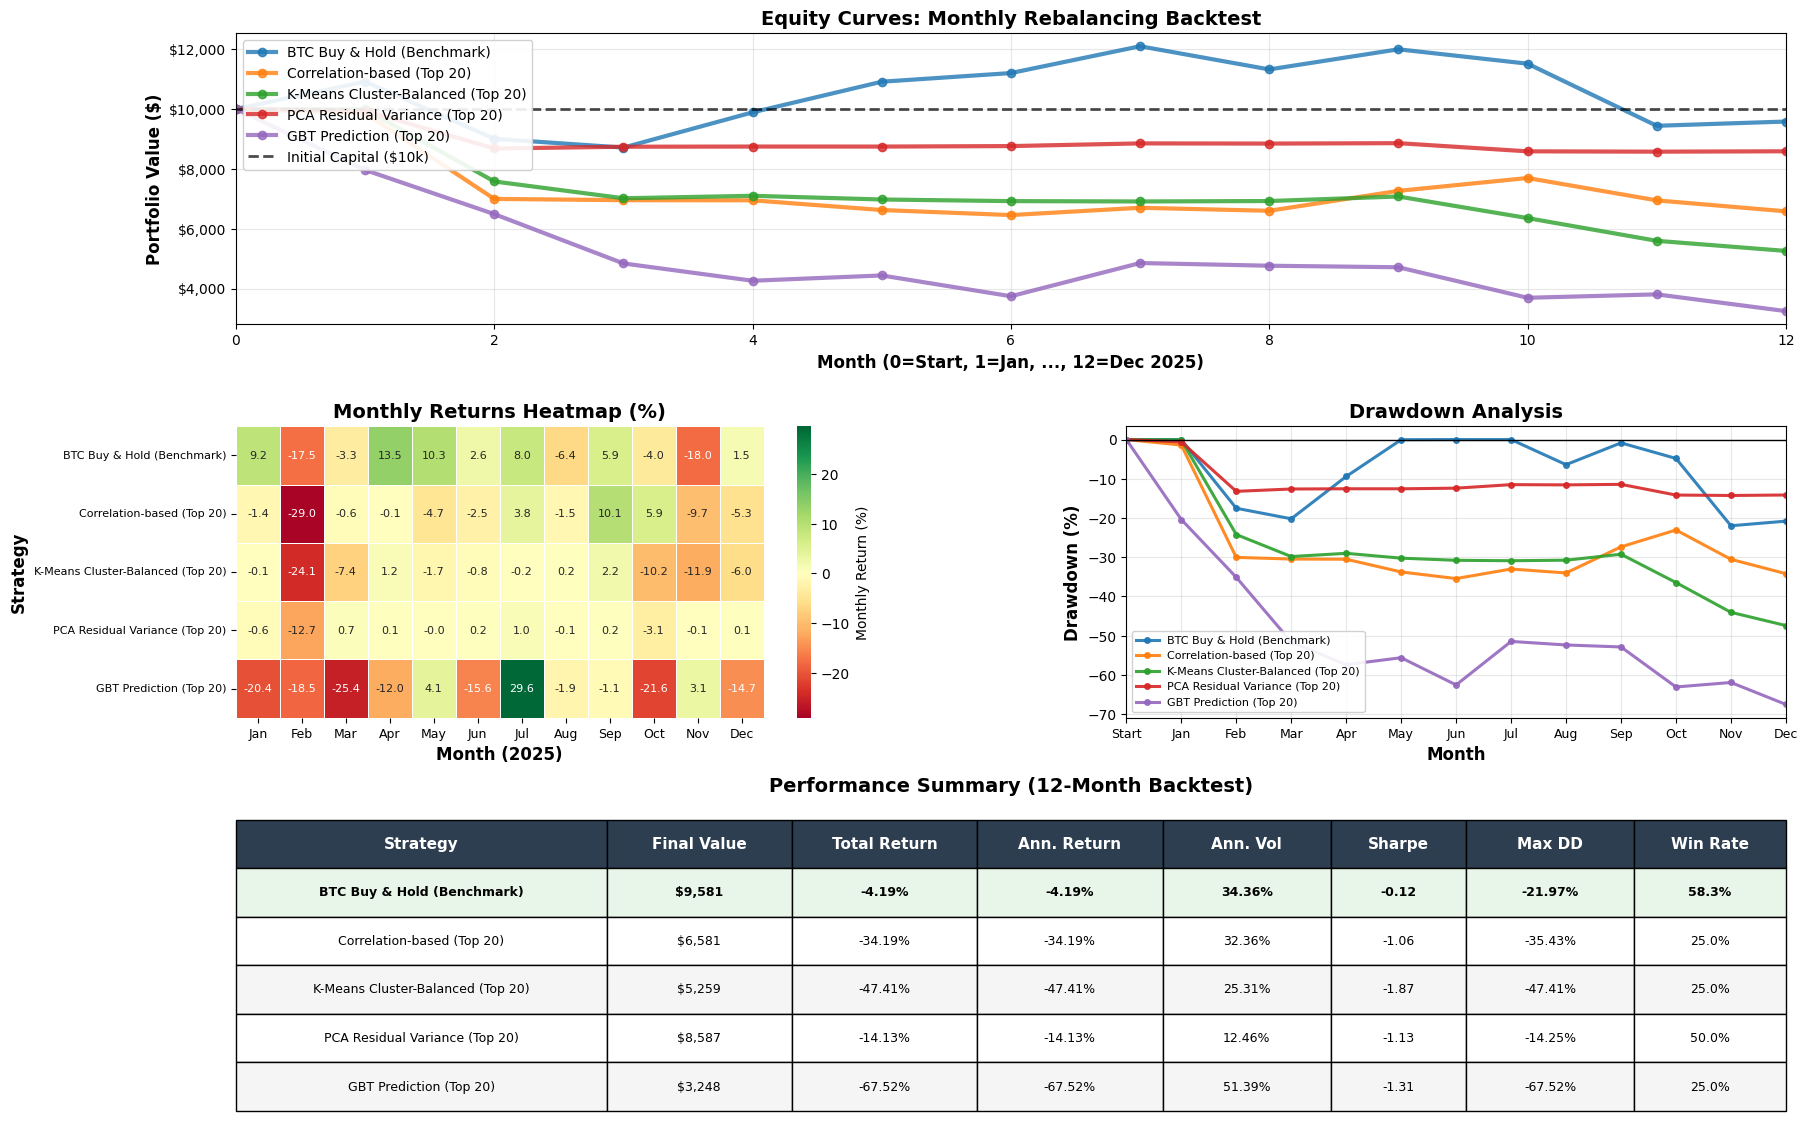

In [15]:
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

colors = {"A": "#1f77b4", "B": "#ff7f0e", "C": "#2ca02c", "D": "#d62728", "E": "#9467bd"}
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.35)

# --- Plot 1: Equity Curves ---
ax1 = fig.add_subplot(gs[0, :])
for strat in STRATEGY_DISPLAY_ORDER:
    months_v = [m for m, _ in equity[strat]]
    vals = [v for _, v in equity[strat]]
    ax1.plot(months_v, vals, marker="o", linewidth=3, markersize=6,
             label=STRATEGY_NAMES[strat], color=colors[strat], alpha=0.8)
ax1.axhline(y=INITIAL_CAPITAL, color="black", linestyle="--", linewidth=2,
             alpha=0.7, label="Initial Capital ($10k)")
ax1.set_xlabel("Month (0=Start, 1=Jan, ..., 12=Dec 2025)", fontsize=12, fontweight="bold")
ax1.set_ylabel("Portfolio Value ($)", fontsize=12, fontweight="bold")
ax1.set_title("Equity Curves: Monthly Rebalancing Backtest", fontsize=14, fontweight="bold")
ax1.legend(loc="upper left", fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 12)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))

# --- Plot 2: Monthly Returns Heatmap ---
ax2 = fig.add_subplot(gs[1, 0])
strat_order = STRATEGY_DISPLAY_ORDER
all_months = sorted(set(r["month"] for r in results))
heatmap_data = np.full((len(strat_order), len(all_months)), np.nan)
for r in results:
    si = strat_order.index(r["strategy"])
    mi = all_months.index(r["month"])
    heatmap_data[si, mi] = r["month_return"] * 100

month_labels = [datetime(BACKTEST_YEAR, m, 1).strftime("%b") for m in all_months]
row_labels = [STRATEGY_NAMES[s] for s in strat_order]

sns.heatmap(heatmap_data, ax=ax2, cmap="RdYlGn", center=0,
            annot=True, fmt=".1f", linewidths=0.6, linecolor="white",
            xticklabels=month_labels, yticklabels=row_labels,
            cbar_kws={"label": "Monthly Return (%)"},
            annot_kws={"fontsize": 8})
ax2.set_xlabel("Month (2025)", fontsize=12, fontweight="bold")
ax2.set_ylabel("Strategy", fontsize=12, fontweight="bold")
ax2.set_title("Monthly Returns Heatmap (%)", fontsize=14, fontweight="bold")
ax2.tick_params(axis="x", labelrotation=0, labelsize=9)
ax2.tick_params(axis="y", labelsize=8)

# --- Plot 3: Drawdown ---
ax3 = fig.add_subplot(gs[1, 1])
for strat in strat_order:
    vals = np.array([v for _, v in equity[strat]])
    peak = np.maximum.accumulate(vals)
    dd = (vals - peak) / peak * 100
    ax3.plot(range(len(vals)), dd, marker="o", linewidth=2.2, markersize=4,
             label=STRATEGY_NAMES[strat], color=colors[strat], alpha=0.9)
ax3.axhline(y=0, color="black", linewidth=1)
ax3.set_xlabel("Month", fontsize=12, fontweight="bold")
ax3.set_ylabel("Drawdown (%)", fontsize=12, fontweight="bold")
ax3.set_title("Drawdown Analysis", fontsize=14, fontweight="bold")
ax3.legend(loc="lower left", fontsize=8, framealpha=0.9)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 12)
ax3.set_xticks(range(13))
ax3.set_xticklabels(["Start"] + [datetime(2025, m, 1).strftime("%b") for m in range(1, 13)],
                     fontsize=9)

# --- Plot 4: Performance Summary Table ---
ax4 = fig.add_subplot(gs[2, :])
ax4.axis("tight")
ax4.axis("off")

headers = ["Strategy", "Final Value", "Total Return", "Ann. Return",
            "Ann. Vol", "Sharpe", "Max DD", "Win Rate"]
table_data = []
best_strat = max(performance, key=lambda s: performance[s]["sharpe"])
for strat in strat_order:
    p = performance[strat]
    table_data.append([
        STRATEGY_NAMES[strat],
        f"${p['final_value']:,.0f}",
        f"{p['total_return']*100:+.2f}%",
        f"{p['ann_return']*100:+.2f}%",
        f"{p['ann_vol']*100:.2f}%",
        f"{p['sharpe']:.2f}",
        f"{p['max_dd']*100:.2f}%",
        f"{p['win_rate']*100:.1f}%",
    ])

table = ax4.table(cellText=table_data, colLabels=headers,
                  cellLoc="center", loc="center", bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2.35)

col_widths = [0.22, 0.11, 0.11, 0.11, 0.10, 0.08, 0.10, 0.09]
for col_i, w in enumerate(col_widths):
    table[(0, col_i)].set_width(w)
    for row_i in range(1, len(table_data) + 1):
        table[(row_i, col_i)].set_width(w)

for i in range(len(headers)):
    table[(0, i)].set_facecolor("#2c3e50")
    table[(0, i)].set_text_props(weight="bold", color="white", fontsize=11)

for i, strat in enumerate(strat_order):
    is_best = strat == best_strat
    bg = "#e8f5e9" if is_best else ("#f5f5f5" if i % 2 == 0 else "white")
    for j in range(len(headers)):
        table[(i + 1, j)].set_facecolor(bg)
        if is_best:
            table[(i + 1, j)].set_text_props(weight="bold")

ax4.set_title("Performance Summary (12-Month Backtest)",
               fontsize=14, fontweight="bold", pad=20)

plt.savefig(f"{OUTPUT_FOLDER}/backtest_comparison.png", dpi=200,
            bbox_inches="tight", facecolor="white")
print(f"Saved: {OUTPUT_FOLDER}/backtest_comparison.png")
plt.show()


### How to Interpret the Visualization

The combined figure provides four complementary views of strategy performance:

**Panel 1: Equity Curves**
- **Y-axis**: Absolute portfolio value in dollars
- **What to look for**:
  - **Slope**: Steeper = higher returns
  - **Smoothness**: Less jagged = lower volatility
  - **Drawdowns**: Sharp drops indicate high risk periods
  - **Recovery**: How quickly portfolios bounce back after losses
- **Red flag**: Portfolios that never recover to previous highs

**Panel 2: Monthly Returns Heatmap**
- **Color coding**: Green (positive) vs. Red (negative) months
- **What to look for**:
  - **Consistency**: Are returns positive most months (darker green)?
  - **Extreme months**: Very dark red (-20%+) indicates crash risk
  - **Correlation**: Do all strategies turn red simultaneously? (market-wide crashes)
  - **Strategy-specific patterns**: Does one strategy consistently outperform in certain months?

**Panel 3: Drawdown Analysis**
- **Y-axis**: Percentage decline from previous peak
- **What to look for**:
  - **Depth**: How far below zero? (deeper = more pain)
  - **Duration**: How long in drawdown? (longer = harder to hold)
  - **Recovery speed**: Steep rebound = resilient strategy
  - **Comparison**: Which strategy has the **shallowest** max drawdown?

**Panel 4: Performance Summary Table**
- **Green highlighting**: Best Sharpe ratio
- **What to look for**:
  - **Sharpe vs. Return tradeoff**: Highest return may not have best Sharpe
  - **Win rate**: Consistency indicator (prefer > 50%)
  - **Max DD**: Downside protection (prefer smallest absolute value)

###  Interpretation

The combined figure helps compare strategies from four angles:
1) equity trajectory,
2) month-level return pattern,
3) drawdown path,
4) final risk/return summary table.

This multi-view presentation makes the backtest conclusions easier to defend in a project report.


## 14. Save Results and Summary


In [16]:
# Save monthly results
with open(f"{OUTPUT_FOLDER}/backtest_results.csv", "w", newline="") as fh:
    w = csv.writer(fh)
    w.writerow(["month", "strategy", "month_return", "num_assets"])
    for r in results:
        w.writerow([r["month"], r["strategy"], r["month_return"], r["num_assets"]])
print(f"Saved: {OUTPUT_FOLDER}/backtest_results.csv")

# Save performance summary
with open(f"{OUTPUT_FOLDER}/backtest_performance.csv", "w", newline="") as fh:
    w = csv.writer(fh)
    w.writerow(["strategy", "total_return", "ann_return", "ann_volatility",
                 "sharpe", "max_drawdown", "win_rate", "final_value"])
    for strat in STRATEGY_DISPLAY_ORDER:
        p = performance[strat]
        w.writerow([strat, p["total_return"], p["ann_return"], p["ann_vol"],
                    p["sharpe"], p["max_dd"], p["win_rate"], p["final_value"]])
print(f"Saved: {OUTPUT_FOLDER}/backtest_performance.csv")

# Save equity curves
with open(f"{OUTPUT_FOLDER}/backtest_equity.csv", "w", newline="") as fh:
    w = csv.writer(fh)
    w.writerow(["month", "strategy", "portfolio_value"])
    for strat in STRATEGY_DISPLAY_ORDER:
        for m, v in equity[strat]:
            w.writerow([m, strat, v])
print(f"Saved: {OUTPUT_FOLDER}/backtest_equity.csv")

# Print best strategy
best = max(performance, key=lambda s: performance[s]["sharpe"])
p = performance[best]
print(f"\nBest strategy by Sharpe: {STRATEGY_NAMES[best]}")
print(f"  Sharpe: {p['sharpe']:.2f}  |  Return: {p['total_return']*100:+.2f}%  "
      f"|  Final: ${p['final_value']:,.2f}")
print(f"\nAll outputs saved to {OUTPUT_FOLDER}/")


Saved: output/backtest_results.csv
Saved: output/backtest_performance.csv
Saved: output/backtest_equity.csv

Best strategy by Sharpe: BTC Buy & Hold (Benchmark)
  Sharpe: -0.12  |  Return: -4.19%  |  Final: $9,581.27

All outputs saved to output/


### Results Interpretation

The CSV files contain:
1. **backtest_results.csv**: Raw monthly returns and asset counts for each strategy
2. **backtest_performance.csv**: Aggregated risk/return metrics for comparison
3. **backtest_equity.csv**: Month-by-month portfolio values for custom visualization

These files enable:
- Reproducible analysis in other tools (R, Excel, Tableau)
- Statistical testing (t-tests, bootstrap confidence intervals)
- Custom visualization and reporting
- Integration with risk management dashboards

## 15. Limitations, Legal and Ethical Notes

- **Data source and licensing:** We use Binance public market data endpoints for educational research.
- **No personal data:** The dataset contains only market candles (no user-level or sensitive information).
- **Delisting handling:** If a selected symbol has no month-end bar, we assign 0% for that month; this is a conservative assumption and should be documented in reports.
- **Tradability constraint:** A symbol is eligible only if it has a price exactly at rebalance timestamp, preventing look-ahead bias.
- **Model risk:** Results depend on lookback length, feature design, and market regime; this notebook is a research backtest, not investment advice.


In [17]:
spark.stop()
print("Spark session stopped. Backtest complete.")

Spark session stopped. Backtest complete.


## 16. Conclusions and Key Findings

### Summary of Results

This backtest evaluated five portfolio strategies over 12 months (Jan–Dec 2025) using strict no-lookahead methodology. 

### Key Insights

**1. Market Regime Dependency**
- 2025 was a challenging year for crypto (negative returns across most strategies)
- Portfolio construction alone cannot overcome adverse market conditions

**2. Diversification Effects**
- Strategies B-E hold 20 assets vs. Strategy A's single asset
- Trade-off: Lower concentration risk but also diluted upside when BTC rallies

**3. Model Complexity vs. Performance**
- Strategy E (GBT ML) is most complex but may not deliver best Sharpe
- Simpler models (correlation filtering, clustering) may be more robust

**4. Tradability Constraints**
- Some strategies held < 20 assets in specific months due to missing rebalance candles
- Real-world execution constraints significantly impact results

### Limitations

**1. Survivorship Bias**
- Dataset includes only assets with data through Dec 2025
- Excludes tokens that failed/delisted earlier
- Results may be optimistic

**2. Transaction Costs**
- Backtest assumes zero fees and slippage
- Reality: ~0.1% fees + 0.1-0.5% slippage per trade
- Actual returns would be lower (20 assets × 12 rebalances × costs)

**3. Market Impact**
- Assumes we can trade at observed prices
- Large orders move prices, especially in illiquid altcoins

**4. Limited Time Period**
- Only 12 months of backtest data
- Results may not generalize to different market regimes

**5. Parameter Selection**
- Parameters chosen based on domain knowledge
- May not be optimal for all market conditions

### Future Extensions

1. Test on multiple years (2023-2025) to cover bull and bear regimes
2. Add transaction cost model
3. Analyze portfolio turnover
4. Try risk parity weighting instead of inverse-vol
5. Test ensemble methods combining multiple strategies

### Conclusion

This notebook demonstrates a backtest framework that:
- Avoids lookahead bias through strict time-windowing
- Enforces realistic tradability constraints
- Scales to hundreds of assets using Spark
- Compares multiple methodologies fairly

The results show that in 2025's market conditions, no strategy achieved strong positive returns. However, the relative ranking provides insights into which approaches are most robust under stress.

## 17. Usage Notes

### Prerequisites

Before running this notebook:
1. Run [01_data_preparation.ipynb](01_data_preparation.ipynb) to prepare data
2. Ensure Spark is installed and Java is available
3. Check that required packages from [requirements.txt](requirements.txt) are installed

### Running the Notebook

1. Select "Run All" to execute the full backtest
2. Wait ~5-15 minutes depending on data size
3. Check `output/` folder for results and visualizations

### Key Parameters (Cell 4)

To modify the backtest, edit these parameters:

```python
INITIAL_CAPITAL = 10000.0      # Starting portfolio value
LOOKBACK_DAYS = 90             # Days of history for model fitting
TOP_N_ASSETS = 20              # Portfolio size (strategies B-E)
BACKTEST_START_MONTH = 1       # First month to trade
BACKTEST_END_MONTH = 12        # Last month to trade
```

### Output Files

| File | Contents |
|------|----------|
| `backtest_results.csv` | Monthly returns per strategy |
| `backtest_performance.csv` | Summary metrics |
| `backtest_equity.csv` | Portfolio values over time |
| `backtest_comparison.png` | Combined visualization |

### Troubleshooting

**"Data not found" error**: Run notebook 01 first to generate parquet files

**Spark memory error**: Increase driver memory in cell 5:
```python
.config("spark.driver.memory", "6g")
```

**Slow execution**: Reduce backtest period for testing:
```python
BACKTEST_END_MONTH = 3  # Test only Q1
```